# Task 2: Experimentation and uplift testing

### Background Information:

As a member of Quantium's retail analytics team, you've been approached by Julia, the Category Manager for Chips, to assess the impact of new trial layouts. Julia seeks a data-driven recommendation on whether to roll out the trial layout to all stores.

### Task:

Julia has requested an evaluation of the performance of a store trial conducted in stores 77, 86, and 88. To begin, utilize the QVI_data dataset provided or your output from Task 1. Focus on analyzing the monthly sales experience of each store, considering metrics such as:

 1. Total sales revenue
 2. Total number of customers
 3. Average number of transactions per customer
 
Develop a measure to compare different control stores to each of the trial stores. Write a function to streamline the analysis process for each trial store, minimizing redundancy. Consider using Pearson correlations or a metric such as a magnitude distance (e.g., 1 - (Observed distance - minimum distance) / (Maximum distance - minimum distance)) as a measure.

Once control stores are identified, compare each trial and control pair during the trial period. Test if total sales are significantly different in the trial period and determine if the driver of change is more purchasing customers or more purchases per customer, among other factors.

#### Key Periods:

1. Period before trial: 07/2018 to 02/2019 (8 months)
2. Trial period: 03/2019 to 06/2019 (4 months)

#### Task Breakdown:

Step 1: Based on the data from the first 8 months, identify the control store for each trial store. The control store should exhibit a similar trend and pattern to the trial store.<br>
Step 2: Compare the data from the last 4 months to assess the impact of the new trial layouts.

For efficient completion of this task, follow these steps to ensure a thorough analysis and provide insightful recommendations to Julia, the Category Manager.








### Step 1: Determine the Control Store

To identify the control store, we need to assess the similarity between each store and a trial store. The store exhibiting the highest similarity will be selected as the control store.

For this analysis, we'll use monthly sales revenue and monthly customer count as the primary metrics to gauge overall similarity.


In [536]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [537]:
df = pd.read_csv('QVI_data.csv')

In [538]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [539]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [540]:
df.rename(columns={ 'DATE':'Date',
                    'STORE_NBR':'Store_number', 
                   'LYLTY_CARD_NBR':'Card_number',
                   'TXN_ID': 'Transaction_id',
                   'PROD_NBR':'Product_number', 
                   'PROD_NAME':'Product_name', 
                   'PROD_QTY':'Product_quantity', 
                   'TOT_SALES':'Total_sales',
                   'PACK_SIZE':'Product_size',
                   'BRAND': 'Product_brand',
                   'PREMIUM_CUSTOMER': 'customer_category'}, inplace=True)

In [541]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Card_number        264834 non-null  int64  
 1   Date               264834 non-null  object 
 2   Store_number       264834 non-null  int64  
 3   Transaction_id     264834 non-null  int64  
 4   Product_number     264834 non-null  int64  
 5   Product_name       264834 non-null  object 
 6   Product_quantity   264834 non-null  int64  
 7   Total_sales        264834 non-null  float64
 8   Product_size       264834 non-null  int64  
 9   Product_brand      264834 non-null  object 
 10  LIFESTAGE          264834 non-null  object 
 11  customer_category  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [542]:
# Format 'DATE' columns
df["Date"] = pd.to_datetime(df["Date"])

In [543]:
df['Date_full']=df['Date']
df['Date'] = df['Date'].dt.strftime('%Y-%m')

# Convert the date column to string
df['Date'] = df['Date'].astype(str)

In [544]:
df.head()

,Card_number,Date,Store_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales,Product_size,Product_brand,LIFESTAGE,customer_category,Date_full
0,1000,2018-10,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10-17
1,1002,2018-09,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16
2,1003,2019-03,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03-07
3,1003,2019-03,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03-08
4,1004,2018-11,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11-02


In [545]:
store_trial = [77,86,88]
all_store = df['Store_number'].unique().tolist()
all_months = df['Date'].unique().tolist()

In [546]:
store_months = []
for i in all_store:
    for j in all_months:
        store_months.append([i, j])
store_months = pd.DataFrame(data=store_months, columns=['Store_number', 'Date'])
store_months.head()

,Store_number,Date
0,1,2018-10
1,1,2018-09
2,1,2019-03
3,1,2018-11
4,1,2018-12


In [547]:
# monthly sales revenue.
monthly_total_sales = df.groupby(['Store_number', 'Date'])['Total_sales'].sum().reset_index(name='sales_revenue')
store_months = store_months.merge(monthly_total_sales, on=['Store_number', 'Date'], how='left')
store_months['sales_revenue'].fillna(0, inplace=True)    # missing value means mean no sales revenue, so replace with 0
store_months.head()

,Store_number,Date,sales_revenue
0,1,2018-10,188.1
1,1,2018-09,278.8
2,1,2019-03,192.9
3,1,2018-11,192.6
4,1,2018-12,189.6


In [548]:
# monthly number of customers
monthly_total_customer = df[['Store_number', 'Date','Card_number']].drop_duplicates().groupby(['Store_number', 'Date']).size().reset_index(name='customer_count')
store_months = store_months.merge(monthly_total_customer, on=['Store_number', 'Date'], how='left')
store_months['customer_count'].fillna(0, inplace=True)     # missing value means no customer, so replace with 0
store_months.head()

,Store_number,Date,sales_revenue,customer_count
0,1,2018-10,188.1,44.0
1,1,2018-09,278.8,59.0
2,1,2019-03,192.9,45.0
3,1,2018-11,192.6,46.0
4,1,2018-12,189.6,42.0


In [549]:
# monthly number of transactions
monthly_transactions = df[['Store_number', 'Date','Transaction_id']].drop_duplicates().groupby(['Store_number', 'Date']).size().reset_index(name='transactions_count')
store_months = store_months.merge(monthly_transactions, on=['Store_number', 'Date'], how='left')
store_months['transactions_count'].fillna(0, inplace=True)     # missing value means no transaction, so replace with 0
store_months.head()

,Store_number,Date,sales_revenue,customer_count,transactions_count
0,1,2018-10,188.1,44.0,45.0
1,1,2018-09,278.8,59.0,62.0
2,1,2019-03,192.9,45.0,49.0
3,1,2018-11,192.6,46.0,47.0
4,1,2018-12,189.6,42.0,47.0


In [550]:
monthly_quantity = df.groupby(['Store_number', 'Date'])['Product_quantity'].sum().reset_index(name='sales_volume')
store_months = store_months.merge(monthly_quantity, on=['Store_number', 'Date'], how='left')
store_months['sales_volume'].fillna(0, inplace=True)
store_months.head()

,Store_number,Date,sales_revenue,customer_count,transactions_count,sales_volume
0,1,2018-10,188.1,44.0,45.0,58.0
1,1,2018-09,278.8,59.0,62.0,75.0
2,1,2019-03,192.9,45.0,49.0,58.0
3,1,2018-11,192.6,46.0,47.0,57.0
4,1,2018-12,189.6,42.0,47.0,57.0


Begin by calculating the correlation coefficient to assess the linear correlation between two stores.

- A higher correlation coefficient suggests that the two stores are positively correlated, meaning they exhibit very similar trends and patterns.
- Conversely, a lower correlation coefficient suggests negative correlation, indicating similar trends and patterns but in opposite directions.
- A correlation coefficient of zero indicates no correlation at all between the two stores.<br>

Identifying the store with the highest correlation coefficient is our objective.

In [551]:


def cal_correlation_coeff(dataset, target_attribute, trial_store):
    # Exclude trial stores
    other_stores = [store for store in all_store if store not in store_trial]
    
    # Define trial months (first 8 months)
    trial_months = [month for month in all_months if pd.to_datetime(month) <= pd.to_datetime('2019-02-01')]
    
    # Extract data of trial store
    trial_store_data = dataset[(dataset['Store_number'] == trial_store) & 
                               (dataset['Date'].isin(trial_months))][target_attribute].tolist()
    
    store_corr = []
    
    # Loop through all stores excluding the trial store
    for store in other_stores:
        # Extract data of another store
        another_store_data = dataset[(dataset['Store_number'] == store) & 
                                     (dataset['Date'].isin(trial_months))][target_attribute].tolist()
        
        # Calculate correlation coefficient
        corr = pd.DataFrame({'trial_shop': trial_store_data, 'another_store': another_store_data}).corr()['another_store'][0]
        store_corr.append([trial_store, store, corr])
    
    # Create DataFrame for correlation coefficients
    trial_store_sales_corr_df = pd.DataFrame(data=store_corr, columns=['trial_store', 'another_store', f"{target_attribute}_corr"])
    
    # Replace missing values with 0
    trial_store_sales_corr_df.fillna(0, inplace=True)
    
    return trial_store_sales_corr_df


Next, compute the difference in key metrics between two stores. It's important to normalize these differences to facilitate their use in measuring similarity alongside the correlation coefficient.

- A higher difference indicates that the values of a metric between two stores are significantly different.
- Conversely, a lower difference suggests that the values of a metric between two stores are relatively close.<br>

It's important to note that there is no inherent relationship between the difference and the correlation coefficient.

In [552]:
def cal_difference(dataset, target_attribute, trial_store):
    # Exclude trial stores
    other_stores = [store for store in all_store if store not in store_trial]
    
    # Define trial months (first 8 months)
    trial_months = [month for month in all_months if pd.to_datetime(month) <= pd.to_datetime('2019-02-01')]
    
    data_df = pd.DataFrame(columns=['Date', 'trial_store', 'another_store', 'target', 'another', 'absolute_diff'])
    
    # Loop through all stores excluding the trial store
    for store in other_stores:
        # Extract data of trial store
        trial_store_data = dataset[(dataset['Store_number'] == trial_store) & 
                                   (dataset['Date'].isin(trial_months))][target_attribute].tolist()
        
        # Extract data of another store
        another_store_data = dataset[(dataset['Store_number'] == store) & 
                                     (dataset['Date'].isin(trial_months))][target_attribute].tolist()
        
        # Create DataFrame for differences
        diff_df = pd.DataFrame({'Date': trial_months, 
                                'trial_store': [trial_store] * len(trial_months),
                                'another_store': [store] * len(trial_months),
                                'target': trial_store_data,
                                'another': another_store_data})
        
        # Calculate absolute difference
        diff_df['absolute_diff'] = np.abs(diff_df['target'] - diff_df['another'])
        
        data_df = pd.concat([data_df, diff_df], axis=0, ignore_index=True)
    
    # Normalize the differences
    data_df['diff_magnitude'] = 1 - (data_df['absolute_diff'] - data_df.groupby('Date')['absolute_diff'].transform('min')) / \
                                  (data_df.groupby('Date')['absolute_diff'].transform('max') - 
                                   data_df.groupby('Date')['absolute_diff'].transform('min'))
    
    # Calculate average difference magnitude
    avg_diff = data_df.groupby(['trial_store', 'another_store'])['diff_magnitude'].mean().reset_index(name=f"{target_attribute}_avg_diff_magnitude")
    
    return avg_diff

Let's find out which store is the control store of the trial store 77.

In [553]:
#
trial_store = 77
# key metrics
metric_1 = 'sales_revenue'
metric_2 = 'customer_count'
# correlation coefficient
metric_1_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)
# difference
metric_1_diff = cal_difference(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_diff = cal_difference(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)

It's clear that the store 233 is the control store (most similar store) of the trial store 77.

In [554]:
store_score = metric_1_corr.merge(metric_2_corr, on=['trial_store','another_store'])
store_score = store_score.merge(metric_1_diff, on=['trial_store','another_store'])
store_score = store_score.merge(metric_2_diff, on=['trial_store','another_store'])
#
store_score['avg_diff'] = store_score[[f'{metric_1}_avg_diff_magnitude', f'{metric_2}_avg_diff_magnitude']].mean(axis=1)
store_score['avg_score'] = store_score[store_score.columns[2:]].mean(axis=1)
store_score.sort_values(by=['avg_score'], ascending=False).head()    # top 5 store with the highest similarity.

,trial_store,another_store,sales_revenue_corr,customer_count_corr,sales_revenue_avg_diff_magnitude,customer_count_avg_diff_magnitude,avg_diff,avg_score
229,77,233,0.894375,0.990542,0.987785,0.993677,0.990731,0.971422
40,77,41,0.632648,0.811844,0.971053,0.970093,0.970573,0.871242
16,77,17,0.843806,0.741196,0.880927,0.965640,0.923284,0.870971
112,77,115,0.684763,0.625048,0.936341,0.964004,0.950172,0.832066
163,77,167,0.653686,0.643155,0.957892,0.940248,0.949070,0.828810


Compare the key metrics between trial store and control store.

In [555]:
# Find the store with the highest similarity (control store)
control_store = store_score.loc[store_score['avg_score'].idxmax(), 'another_store']

# Extract data for the control store
control_data = store_months[store_months['Store_number'] == control_store].reset_index(drop=True)
control_data['store_type'] = f'control store {control_store}'

# Extract data for the trial store
trial_data = store_months[store_months['Store_number'] == trial_store].reset_index(drop=True)
trial_data['store_type'] = f'trial store {trial_store}'

# Combine data for trial and control stores
trial_control_data = pd.concat([control_data, trial_data], ignore_index=True)

# Display the combined data
trial_control_data.head()

,Store_number,Date,sales_revenue,customer_count,transactions_count,sales_volume,store_type
0,233,2018-10,185.7,35.0,36.0,56.0,control store 233
1,233,2018-09,228.6,42.0,45.0,70.0,control store 233
2,233,2019-03,199.1,40.0,41.0,59.0,control store 233
3,233,2018-11,211.6,40.0,41.0,62.0,control store 233
4,233,2018-12,279.8,47.0,50.0,75.0,control store 233


We can clearly see, in the trial period, two stores display very different trend and pattern.

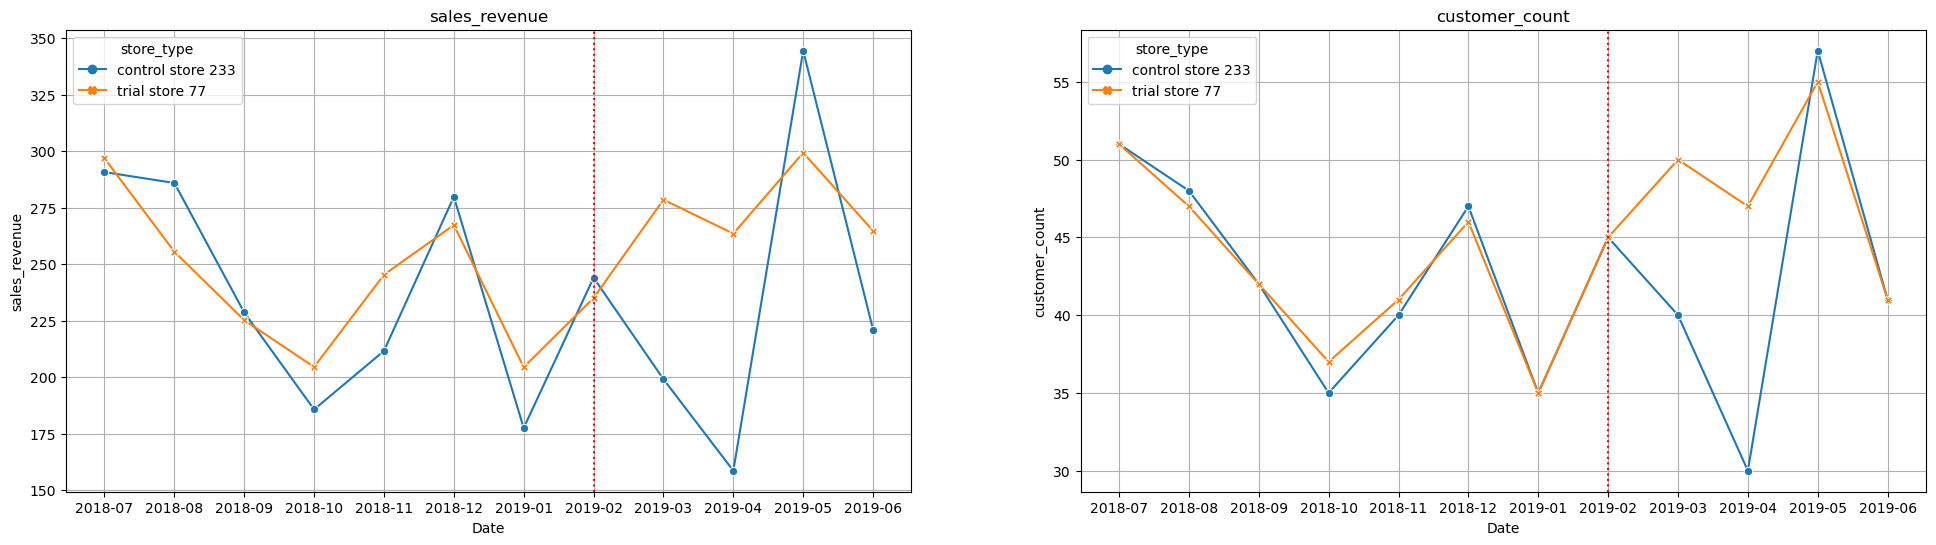

In [556]:
# Sort the DataFrame by 'Date'
trial_control_data_sorted = trial_control_data.sort_values(by='Date')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Plot for Sales revenue
sns.lineplot(data=trial_control_data_sorted, x='Date', y=metric_1, hue='store_type', markers=True, style="store_type", dashes=False, ax=axes[0])
axes[0].axvline('2019-02', color='red', linestyle='dotted')
axes[0].grid()
axes[0].set_title(metric_1)

# Plot for Number of customers
sns.lineplot(data=trial_control_data_sorted, x='Date', y=metric_2, hue='store_type', markers=True, style="store_type", dashes=False, ax=axes[1])
axes[1].axvline('2019-02', color='red', linestyle='dotted')
axes[1].grid()
axes[1].set_title(metric_2)

# Display the plot
plt.show()

Let's calculate the difference in key metrics between two stores. The ratio of differnece to metric value of control store can display clearer patterns.

In [557]:
# Create a DataFrame to store the differences and difference percentages
trial_control_diff = control_data[['Date']].copy()
trial_control_diff['Date'] = pd.to_datetime(trial_control_diff['Date'])
trial_control_diff[f'{metric_1}_diff'] = trial_data[metric_1] - control_data[metric_1]
trial_control_diff[f'{metric_2}_diff'] = trial_data[metric_2] - control_data[metric_2]
trial_control_diff[f'{metric_1}_diff_percent'] = trial_control_diff[f'{metric_1}_diff'] / control_data[metric_1] * 100
trial_control_diff[f'{metric_2}_diff_percent'] = trial_control_diff[f'{metric_2}_diff'] / control_data[metric_2] * 100

# Display the DataFrame
trial_control_diff


,Date,sales_revenue_diff,customer_count_diff,sales_revenue_diff_percent,customer_count_diff_percent
0,2018-10-01,18.8,2.0,10.123856,5.714286
1,2018-09-01,-3.4,0.0,-1.487314,0.000000
2,2019-03-01,79.4,10.0,39.879458,25.000000
3,2018-11-01,33.7,1.0,15.926276,2.500000
4,2018-12-01,-12.5,-1.0,-4.467477,-2.127660
5,2018-07-01,6.1,0.0,2.098383,0.000000
6,2019-06-01,43.7,0.0,19.773756,0.000000
7,2019-04-01,104.9,17.0,66.141236,56.666667
8,2019-01-01,26.9,0.0,15.154930,0.000000
9,2018-08-01,-30.4,-1.0,-10.633088,-2.083333


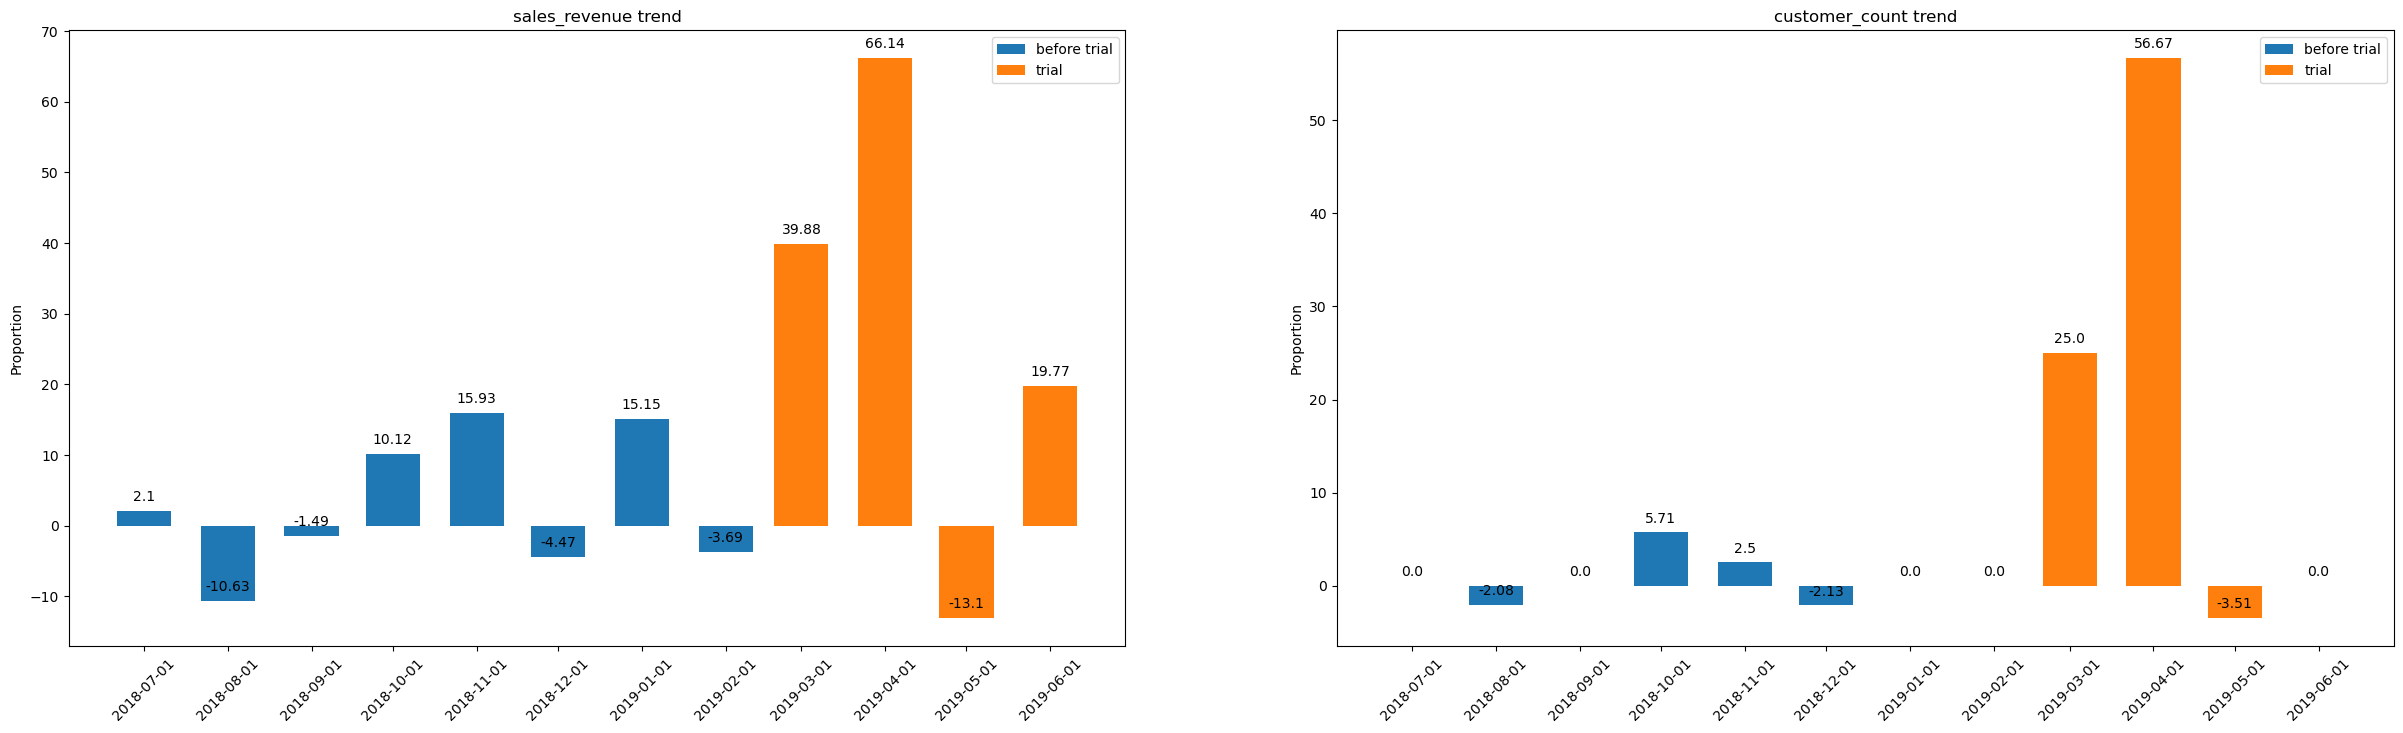

In [558]:


# Assuming trial_control_diff['Date'] is of type numpy.datetime64

fig, ax = plt.subplots(1, 2, figsize=(30, 8))  # Increased figure size to (30, 8)

# Plot for metric 1 trend
before_trial_metric_1 = trial_control_diff[trial_control_diff['Date'] <= '2019-02-01']
trial_metric_1 = trial_control_diff[trial_control_diff['Date'] > '2019-02-01']

combined_dates_1 = np.union1d(trial_metric_1['Date'].unique(), before_trial_metric_1['Date'].unique())

ax[0].bar(before_trial_metric_1['Date'], before_trial_metric_1[f'{metric_1}_diff_percent'], width=20, label='before trial')
ax[0].bar(trial_metric_1['Date'], trial_metric_1[f'{metric_1}_diff_percent'], width=20, label='trial')

for p in ax[0].patches:
    ax[0].annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[0].set_xticks(combined_dates_1)  # Set x-ticks to combined unique dates
ax[0].set_xticklabels([str(date)[:10] for date in combined_dates_1], rotation=45)  # Format x-tick labels
ax[0].set_title(f'{metric_1} trend')
ax[0].legend()
ax[0].set_ylabel('Proportion')

# Plot for metric 2 trend
before_trial_metric_2 = trial_control_diff[trial_control_diff['Date'] <= '2019-02-01']
trial_metric_2 = trial_control_diff[trial_control_diff['Date'] > '2019-02-01']

combined_dates_2 = np.union1d(trial_metric_2['Date'].unique(), before_trial_metric_2['Date'].unique())

ax[1].bar(before_trial_metric_2['Date'], before_trial_metric_2[f'{metric_2}_diff_percent'], width=20, label='before trial')
ax[1].bar(trial_metric_2['Date'], trial_metric_2[f'{metric_2}_diff_percent'], width=20, label='trial')

for p in ax[1].patches:
    ax[1].annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].set_xticks(combined_dates_2)  # Set x-ticks to combined unique dates
ax[1].set_xticklabels([str(date)[:10] for date in combined_dates_2], rotation=45)  # Format x-tick labels
ax[1].set_title(f'{metric_2} trend')
ax[1].legend()
ax[1].set_ylabel('Proportion')

plt.show()


#### Sales revenue
- The new trial layouts had a significant, positive impact on sales revenue (increase by up to 66%) in April.
- As the maximum difference in sales revenue during the period before trial reached 15%, the difference in March might not be caused by the new trial layouts.
- The new trial layouts seemed to have a positive impact in June and a nagetive impact in May.

#### Number of customers
- The new trial layouts had a significant, positive impact on the number of customers (increase by up to 56%) in April.
- As the maximum difference in the number of customers during the period before trial reached 5%, the difference in March might not completely be caused by the new trial layouts.
- The new trial layouts had a weak impact in May and June.

Let's find out which store is the control store of the trial store 86.

In [559]:
# Define trial store and key metrics
trial_store = 86
metric_1 = 'sales_revenue'
metric_2 = 'customer_count'

# Calculate correlation coefficients
metric_1_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)

# Calculate differences
metric_1_diff = cal_difference(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_diff = cal_difference(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)


We can see the store 155 is the control store (most similar store) of the trial store 86

In [560]:
# Merge correlation coefficients and differences
store_score = metric_1_corr.merge(metric_2_corr, on=['trial_store','another_store']) \
                          .merge(metric_1_diff, on=['trial_store','another_store']) \
                          .merge(metric_2_diff, on=['trial_store','another_store'])

# Calculate average difference and average score
store_score['avg_diff'] = store_score[[f'{metric_1}_avg_diff_magnitude', f'{metric_2}_avg_diff_magnitude']].mean(axis=1)
store_score['avg_score'] = store_score.iloc[:, 2:].mean(axis=1)

# Get top 5 stores with the highest similarity
top_similar_stores = store_score.sort_values(by='avg_score', ascending=False).head()

# Display top 5 similar stores
top_similar_stores


,trial_store,another_store,sales_revenue_corr,customer_count_corr,sales_revenue_avg_diff_magnitude,customer_count_avg_diff_magnitude,avg_diff,avg_score
84,86,155,0.841589,0.646118,0.966684,0.973135,0.969909,0.879487
144,86,147,0.573664,0.728606,0.919525,0.918428,0.918976,0.811840
106,86,109,0.674976,0.404255,0.961321,0.952053,0.956687,0.789858
225,86,229,0.418894,0.575004,0.945319,0.959081,0.952200,0.770099
168,86,172,0.543856,0.458727,0.934013,0.929020,0.931517,0.759427


Compare the key metrics between trial store and control store.

In [561]:
# the store with the highest similarity
control_store = store_score.sort_values(by=['avg_score'], ascending=False)['another_store'].values[0]
# 
control_data = store_months[store_months['Store_number']==control_store].reset_index(drop=True)
control_data['store_type'] = f'control store {control_store}'
trial_data = store_months[store_months['Store_number']==trial_store].reset_index(drop=True)
trial_data['store_type'] = f'trial store {trial_store}'
#
trial_control_data = pd.concat([control_data, trial_data], ignore_index=True)
trial_control_data.head()

,Store_number,Date,sales_revenue,customer_count,transactions_count,sales_volume,store_type
0,155,2018-10,963.8,108.0,136.0,272.0,control store 155
1,155,2018-09,1014.4,103.0,144.0,290.0,control store 155
2,155,2019-03,804.4,94.0,118.0,240.0,control store 155
3,155,2018-11,898.8,101.0,133.0,270.0,control store 155
4,155,2018-12,849.8,97.0,120.0,242.0,control store 155


We can clearly see, in the trial period, two stores display very different trend and pattern.

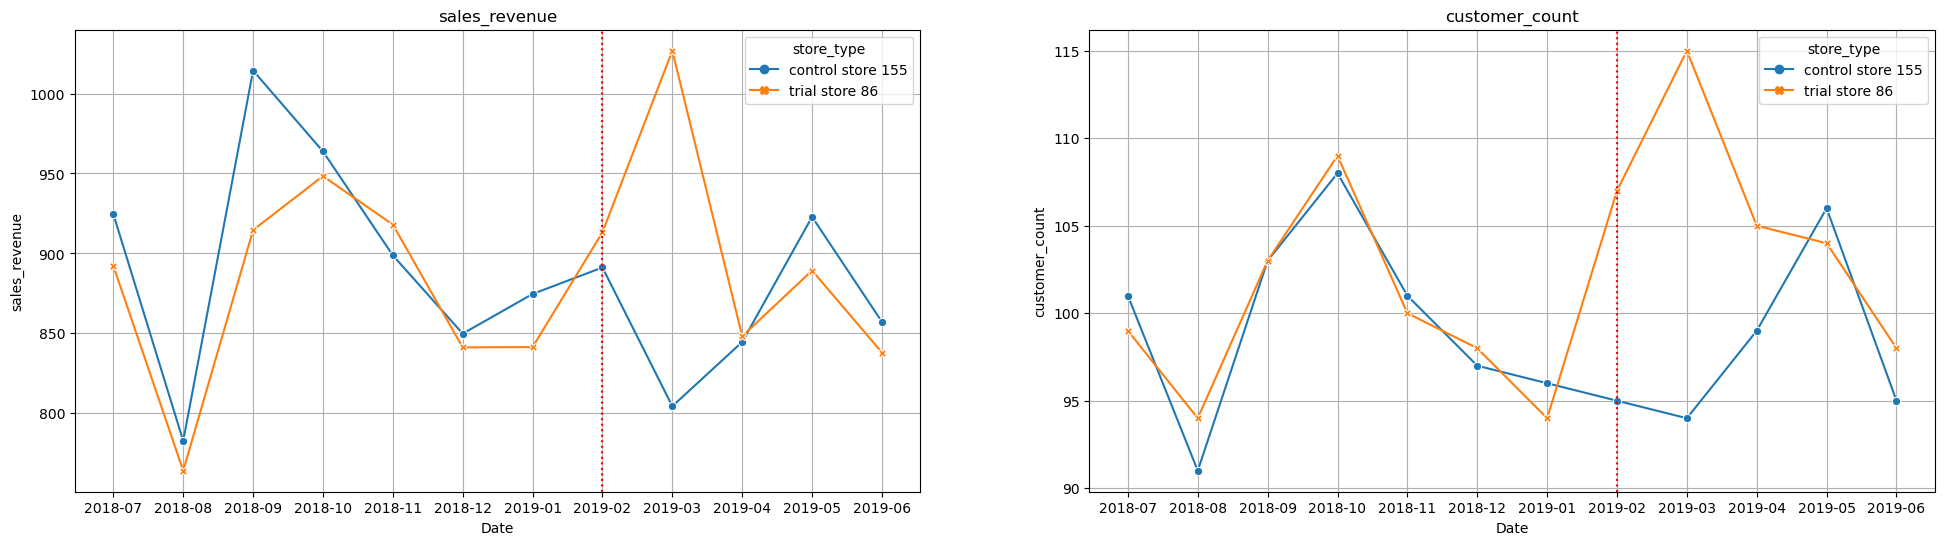

In [562]:
trial_control_data_sorted = trial_control_data.sort_values(by='Date')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Plot for Sales revenue
sns.lineplot(data=trial_control_data_sorted, x='Date', y=metric_1, hue='store_type', markers=True, style="store_type", dashes=False, ax=axes[0])
axes[0].axvline('2019-02', color='red', linestyle='dotted')
axes[0].grid()
axes[0].set_title(metric_1)

# Plot for Number of customers
sns.lineplot(data=trial_control_data_sorted, x='Date', y=metric_2, hue='store_type', markers=True, style="store_type", dashes=False, ax=axes[1])
axes[1].axvline('2019-02', color='red', linestyle='dotted')
axes[1].grid()
axes[1].set_title(metric_2)

# Display the plot
plt.show()

In [563]:
# Create a DataFrame to store the differences and difference percentages
trial_control_diff = control_data[['Date']].copy()
trial_control_diff['Date'] = pd.to_datetime(trial_control_diff['Date'])
trial_control_diff[f'{metric_1}_diff'] = trial_data[metric_1] - control_data[metric_1]
trial_control_diff[f'{metric_2}_diff'] = trial_data[metric_2] - control_data[metric_2]
trial_control_diff[f'{metric_1}_diff_percent'] = trial_control_diff[f'{metric_1}_diff'] / control_data[metric_1] * 100
trial_control_diff[f'{metric_2}_diff_percent'] = trial_control_diff[f'{metric_2}_diff'] / control_data[metric_2] * 100

# Display the DataFrame
trial_control_diff


,Date,sales_revenue_diff,customer_count_diff,sales_revenue_diff_percent,customer_count_diff_percent
0,2018-10-01,-15.40,1.0,-1.597842,0.925926
1,2018-09-01,-99.80,0.0,-9.838328,0.000000
2,2019-03-01,222.40,21.0,27.647936,22.340426
3,2018-11-01,19.20,-1.0,2.136182,-0.990099
4,2018-12-01,-8.60,1.0,-1.012003,1.030928
5,2018-07-01,-32.40,-2.0,-3.504218,-1.980198
6,2019-06-01,-19.20,3.0,-2.239851,3.157895
7,2019-04-01,3.60,6.0,0.426237,6.060606
8,2019-01-01,-33.20,-2.0,-3.796021,-2.083333
9,2018-08-01,-18.65,3.0,-2.382778,3.296703


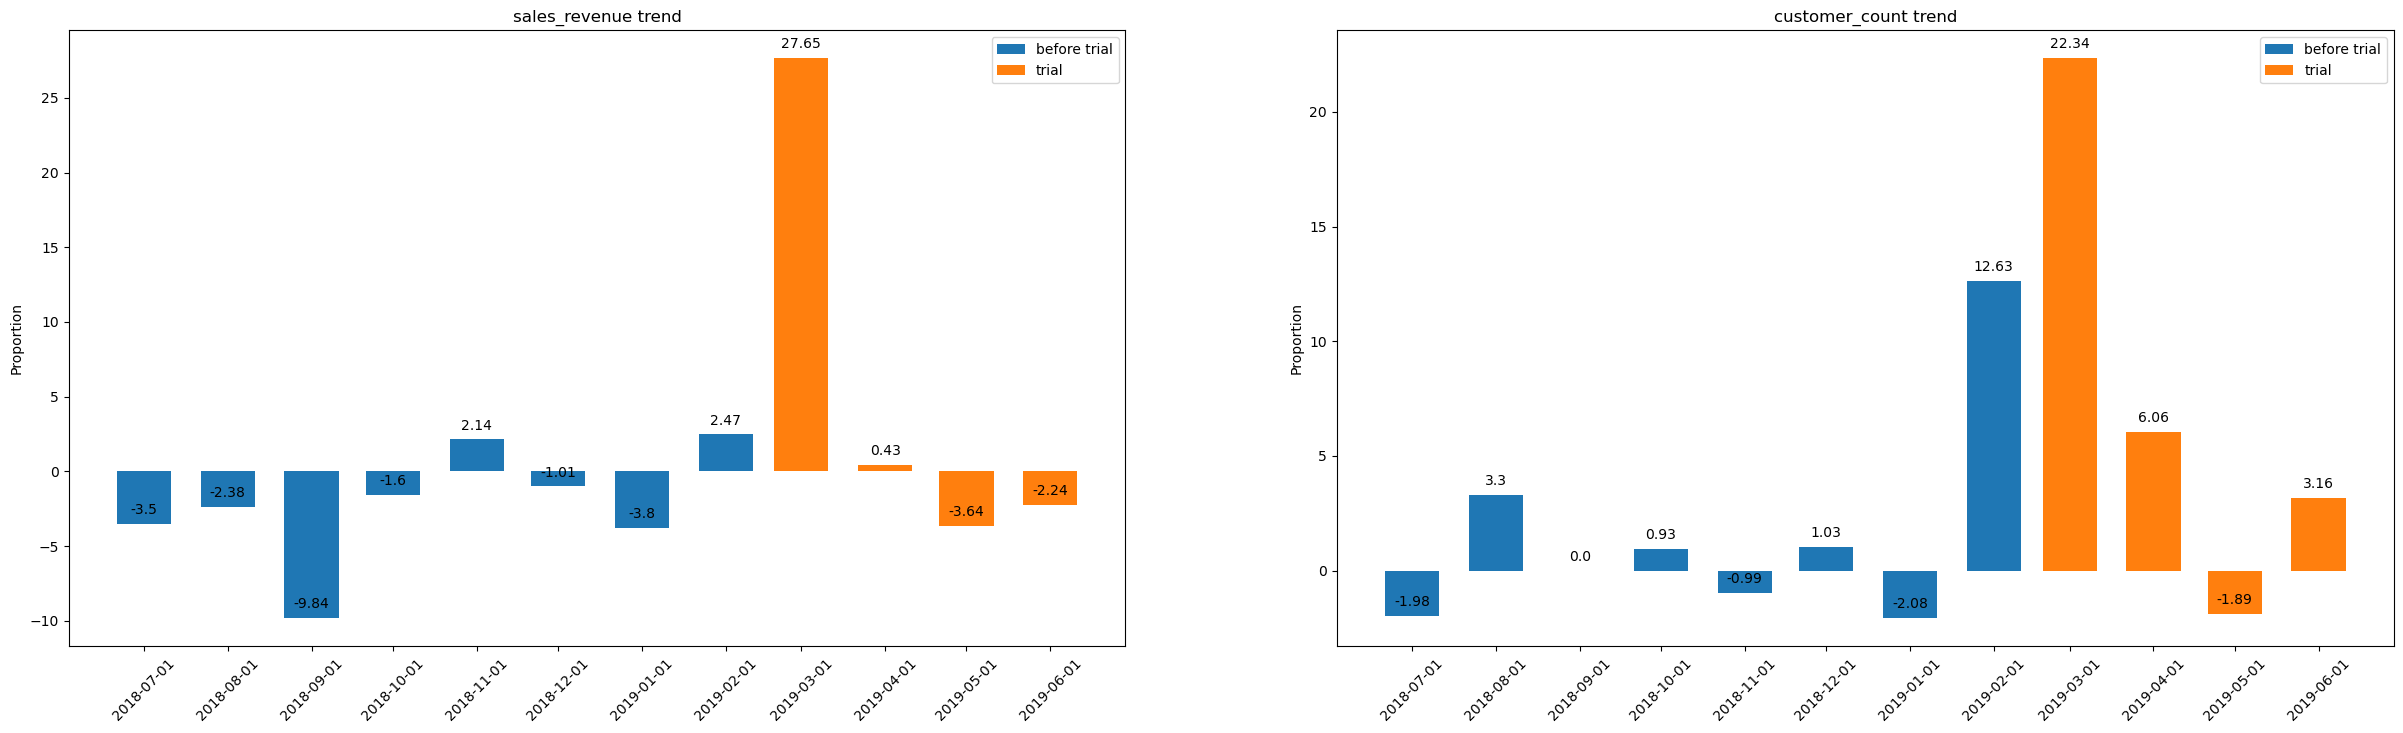

In [564]:

fig, ax = plt.subplots(1, 2, figsize=(30, 8))  # Increased figure size to (30, 8)

# Plot for metric 1 trend
before_trial_metric_1 = trial_control_diff[trial_control_diff['Date'] <= '2019-02-01']
trial_metric_1 = trial_control_diff[trial_control_diff['Date'] > '2019-02-01']

combined_dates_1 = np.union1d(trial_metric_1['Date'].unique(), before_trial_metric_1['Date'].unique())

ax[0].bar(before_trial_metric_1['Date'], before_trial_metric_1[f'{metric_1}_diff_percent'], width=20, label='before trial')
ax[0].bar(trial_metric_1['Date'], trial_metric_1[f'{metric_1}_diff_percent'], width=20, label='trial')

for p in ax[0].patches:
    ax[0].annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[0].set_xticks(combined_dates_1)  # Set x-ticks to combined unique dates
ax[0].set_xticklabels([str(date)[:10] for date in combined_dates_1], rotation=45)  # Format x-tick labels
ax[0].set_title(f'{metric_1} trend')
ax[0].legend()
ax[0].set_ylabel('Proportion')

# Plot for metric 2 trend
before_trial_metric_2 = trial_control_diff[trial_control_diff['Date'] <= '2019-02-01']
trial_metric_2 = trial_control_diff[trial_control_diff['Date'] > '2019-02-01']

combined_dates_2 = np.union1d(trial_metric_2['Date'].unique(), before_trial_metric_2['Date'].unique())

ax[1].bar(before_trial_metric_2['Date'], before_trial_metric_2[f'{metric_2}_diff_percent'], width=20, label='before trial')
ax[1].bar(trial_metric_2['Date'], trial_metric_2[f'{metric_2}_diff_percent'], width=20, label='trial')

for p in ax[1].patches:
    ax[1].annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].set_xticks(combined_dates_2)  # Set x-ticks to combined unique dates
ax[1].set_xticklabels([str(date)[:10] for date in combined_dates_2], rotation=45)  # Format x-tick labels
ax[1].set_title(f'{metric_2} trend')
ax[1].legend()
ax[1].set_ylabel('Proportion')

plt.show()


#### Sales revenue
- The new trial layouts had a significant, positive impact on sales revenue (increase by up to 27%) in March and had a weak impact in the remaining 3 months.

#### Number of customers
- As the maximum difference in number of customers during the period before trial reached 12%, the difference in March might not completely be caused by the new trial layouts. So, the new trial layouts seemed to have a positive impact on number of customers in March.
- During the remaining 3 months, the new trial layouts had a weak impact on the number of customers.

In [565]:
# Define trial store and key metrics
trial_store = 88
metric_1 = 'sales_revenue'
metric_2 = 'customer_count'

# Calculate correlation coefficients
metric_1_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)

# Calculate differences
metric_1_diff = cal_difference(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_diff = cal_difference(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)


In [566]:
# 
store_score = metric_1_corr.merge(metric_2_corr, on=['trial_store','another_store'])
store_score = store_score.merge(metric_1_diff, on=['trial_store','another_store'])
store_score = store_score.merge(metric_2_diff, on=['trial_store','another_store'])
store_score['avg_score'] = store_score[store_score.columns[2:]].mean(axis=1)
store_score.sort_values(by=['avg_score'], ascending=False).head()    # top 5 store with the highest similarity.

,trial_store,another_store,sales_revenue_corr,customer_count_corr,sales_revenue_avg_diff_magnitude,customer_count_avg_diff_magnitude,avg_score
233,88,237,0.353432,0.942232,0.963378,0.994045,0.813272
174,88,178,0.614742,0.873835,0.713219,0.834277,0.759018
68,88,69,0.403862,0.817853,0.707638,0.875897,0.701312
120,88,123,0.418839,0.593049,0.864557,0.910142,0.696647
197,88,201,0.426486,0.523800,0.872728,0.924678,0.686923


In [567]:
# the store with the highest similarity
control_store = store_score.sort_values(by=['avg_score'], ascending=False)['another_store'].values[0]
# 
control_data = store_months[store_months['Store_number']==control_store].reset_index(drop=True)
control_data['store_type'] = f'control store {control_store}'
trial_data = store_months[store_months['Store_number']==trial_store].reset_index(drop=True)
trial_data['store_type'] = f'trial store {trial_store}'
#
trial_control_data = pd.concat([control_data, trial_data], ignore_index=True)
trial_control_data.head()

,Store_number,Date,sales_revenue,customer_count,transactions_count,sales_volume,store_type
0,237,2018-10,1348.3,123.0,147.0,299.0,control store 237
1,237,2018-09,1322.2,126.0,149.0,299.0,control store 237
2,237,2019-03,1208.2,119.0,134.0,274.0,control store 237
3,237,2018-11,1397.6,132.0,161.0,320.0,control store 237
4,237,2018-12,1265.0,124.0,144.0,289.0,control store 237


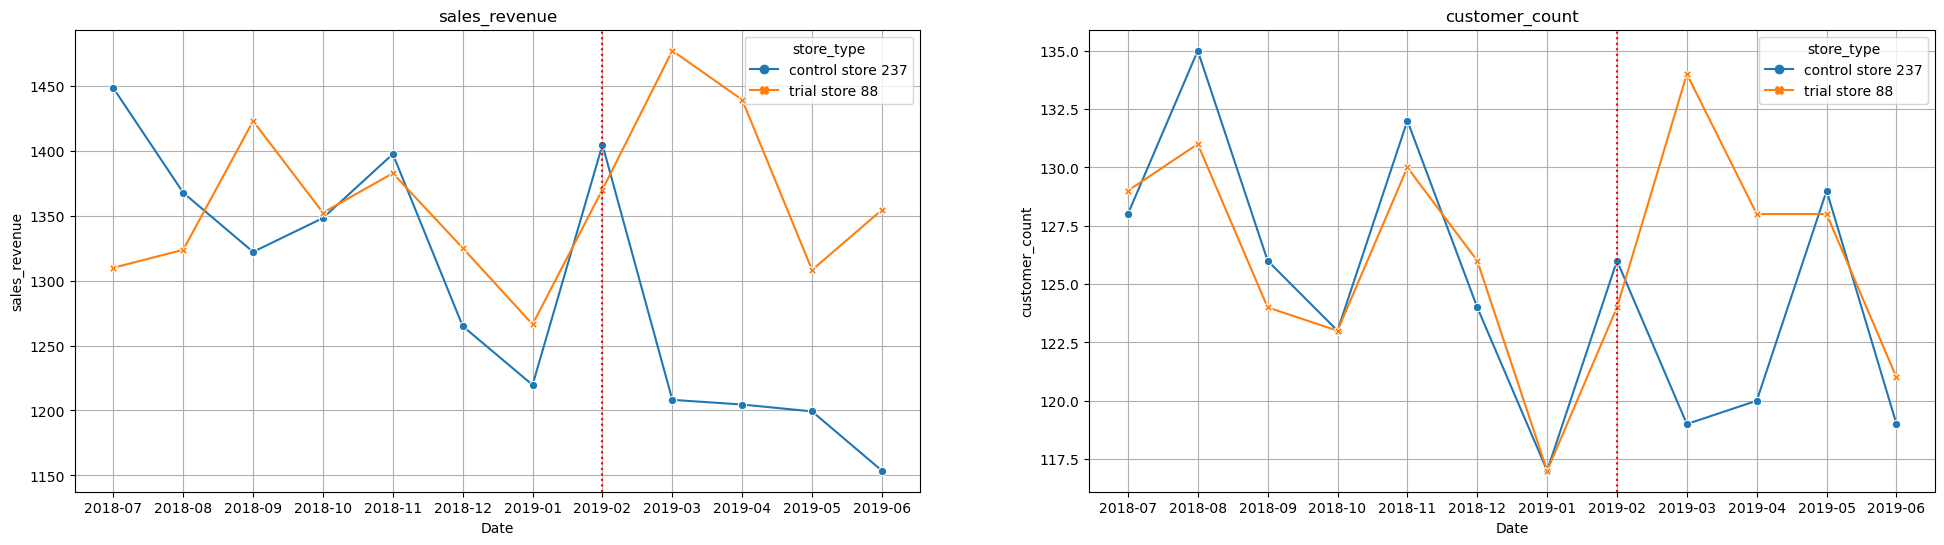

In [568]:
trial_control_data_sorted = trial_control_data.sort_values(by='Date')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Plot for Sales revenue
sns.lineplot(data=trial_control_data_sorted, x='Date', y=metric_1, hue='store_type', markers=True, style="store_type", dashes=False, ax=axes[0])
axes[0].axvline('2019-02', color='red', linestyle='dotted')
axes[0].grid()
axes[0].set_title(metric_1)

# Plot for Number of customers
sns.lineplot(data=trial_control_data_sorted, x='Date', y=metric_2, hue='store_type', markers=True, style="store_type", dashes=False, ax=axes[1])
axes[1].axvline('2019-02', color='red', linestyle='dotted')
axes[1].grid()
axes[1].set_title(metric_2)

# Display the plot
plt.show()

In [569]:
# Create a DataFrame to store the differences and difference percentages
trial_control_diff = control_data[['Date']].copy()
trial_control_diff['Date'] = pd.to_datetime(trial_control_diff['Date'])
trial_control_diff[f'{metric_1}_diff'] = trial_data[metric_1] - control_data[metric_1]
trial_control_diff[f'{metric_2}_diff'] = trial_data[metric_2] - control_data[metric_2]
trial_control_diff[f'{metric_1}_diff_percent'] = trial_control_diff[f'{metric_1}_diff'] / control_data[metric_1] * 100
trial_control_diff[f'{metric_2}_diff_percent'] = trial_control_diff[f'{metric_2}_diff'] / control_data[metric_2] * 100

# Display the DataFrame
trial_control_diff


,Date,sales_revenue_diff,customer_count_diff,sales_revenue_diff_percent,customer_count_diff_percent
0,2018-10-01,4.10,0.0,0.304087,0.000000
1,2018-09-01,100.80,-2.0,7.623658,-1.587302
2,2019-03-01,269.00,15.0,22.264526,12.605042
3,2018-11-01,-14.80,-2.0,-1.058958,-1.515152
4,2018-12-01,60.20,2.0,4.758893,1.612903
5,2018-07-01,-138.40,1.0,-9.555371,0.781250
6,2019-06-01,201.00,2.0,17.423717,1.680672
7,2019-04-01,234.80,8.0,19.491948,6.666667
8,2019-01-01,46.70,0.0,3.828810,0.000000
9,2018-08-01,-44.00,-4.0,-3.216845,-2.962963


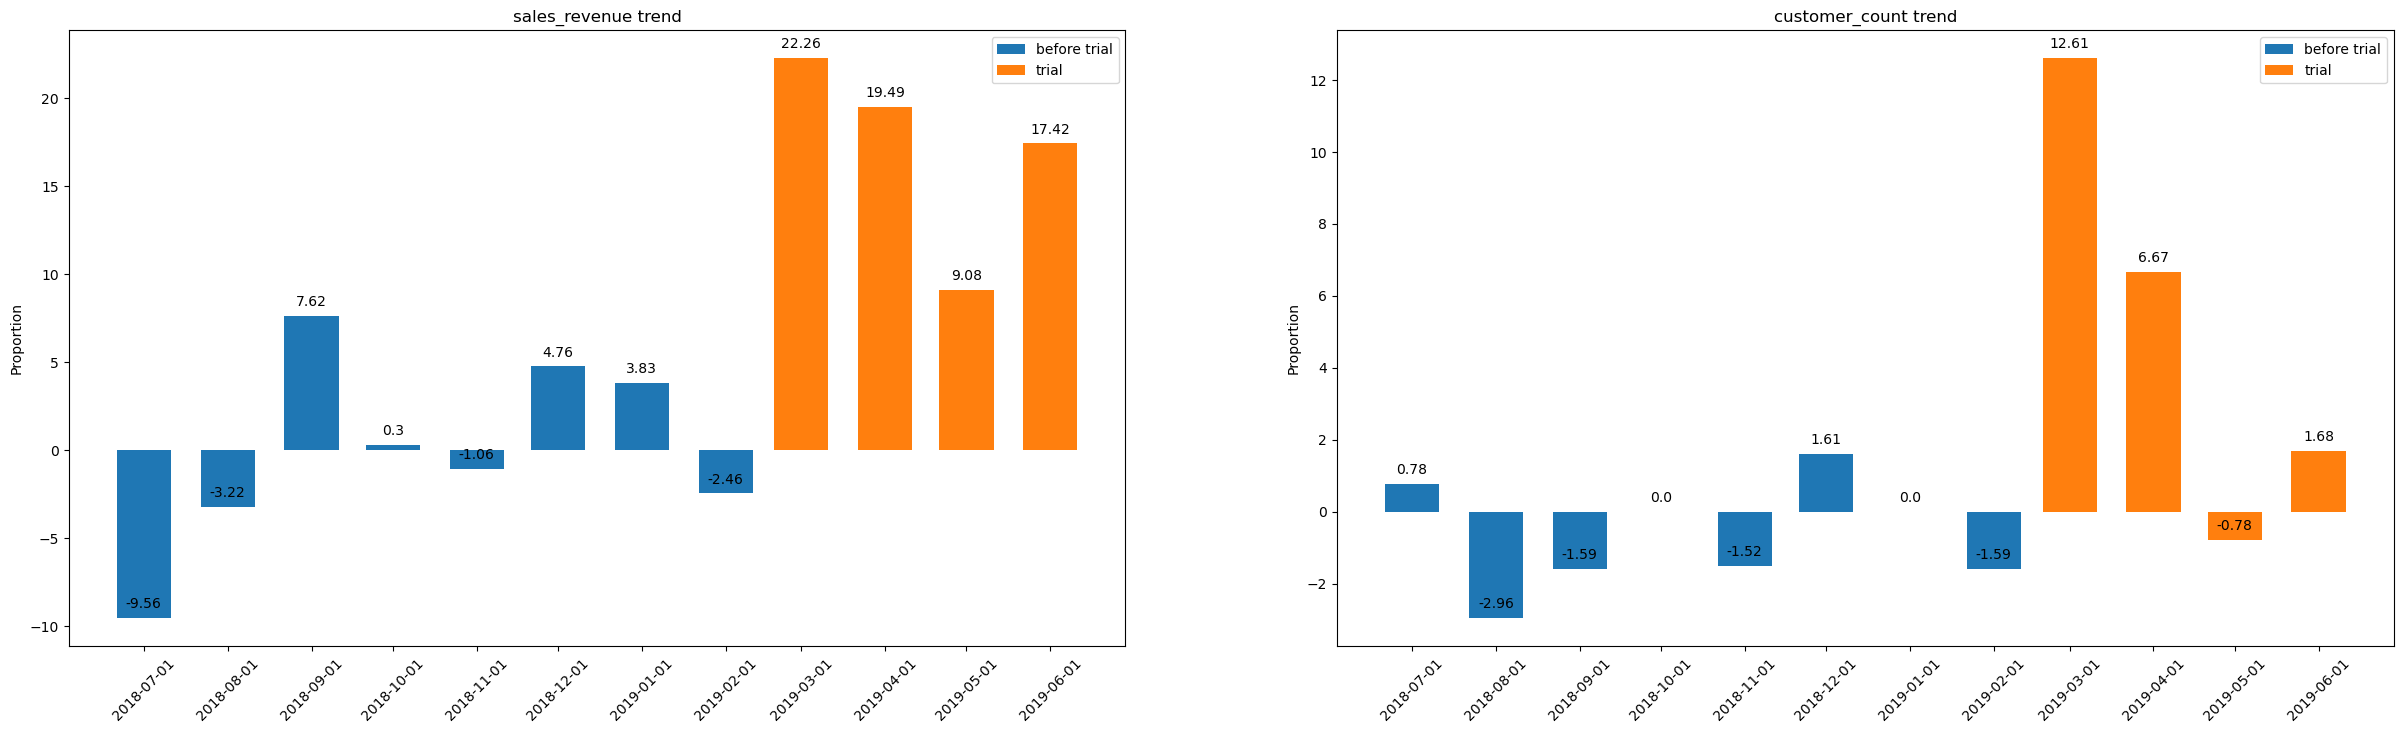

In [570]:



fig, ax = plt.subplots(1, 2, figsize=(30, 8))  # Increased figure size to (30, 8)

# Plot for metric 1 trend
before_trial_metric_1 = trial_control_diff[trial_control_diff['Date'] <= '2019-02-01']
trial_metric_1 = trial_control_diff[trial_control_diff['Date'] > '2019-02-01']

combined_dates_1 = np.union1d(trial_metric_1['Date'].unique(), before_trial_metric_1['Date'].unique())

ax[0].bar(before_trial_metric_1['Date'], before_trial_metric_1[f'{metric_1}_diff_percent'], width=20, label='before trial')
ax[0].bar(trial_metric_1['Date'], trial_metric_1[f'{metric_1}_diff_percent'], width=20, label='trial')

for p in ax[0].patches:
    ax[0].annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[0].set_xticks(combined_dates_1)  # Set x-ticks to combined unique dates
ax[0].set_xticklabels([str(date)[:10] for date in combined_dates_1], rotation=45)  # Format x-tick labels
ax[0].set_title(f'{metric_1} trend')
ax[0].legend()
ax[0].set_ylabel('Proportion')

# Plot for metric 2 trend
before_trial_metric_2 = trial_control_diff[trial_control_diff['Date'] <= '2019-02-01']
trial_metric_2 = trial_control_diff[trial_control_diff['Date'] > '2019-02-01']

combined_dates_2 = np.union1d(trial_metric_2['Date'].unique(), before_trial_metric_2['Date'].unique())

ax[1].bar(before_trial_metric_2['Date'], before_trial_metric_2[f'{metric_2}_diff_percent'], width=20, label='before trial')
ax[1].bar(trial_metric_2['Date'], trial_metric_2[f'{metric_2}_diff_percent'], width=20, label='trial')

for p in ax[1].patches:
    ax[1].annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].set_xticks(combined_dates_2)  # Set x-ticks to combined unique dates
ax[1].set_xticklabels([str(date)[:10] for date in combined_dates_2], rotation=45)  # Format x-tick labels
ax[1].set_title(f'{metric_2} trend')
ax[1].legend()
ax[1].set_ylabel('Proportion')

plt.show()


#### Sales revenue
- The new trial layouts had a significant, positive impact on sales revenue (increase by up to 22%) in March.
- The new trial layouts seemed to have a positive impact in the remaining 3 months.

#### Number of customers
- The new trial layouts had a significant, positive impact on the number of customers (increase by up to 12%) in March.
- The new trial layouts seemed to have a positive impact in April
- The new trial layouts seemed to have a weak impact in May
- The new trial layouts seemed to have a nagetive impact in June

### Overall

- The new trial layouts had a positive impact on sales revenue and number of customers in March and April.
- In May and June, the new trial layouts seemed to have a weak impact.